In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tabulate
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-07-05 18:29:33 - ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-07-05 18:29:33 - src.ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-07-05 18:29:34 - wandb.docker.auth - DEBUG    - Trying paths: ['/Users/guydavidson/.docker/config.json', '/Users/guydavidson/.dockercfg']
2023-07-05 18:29:34 - wandb.docker.auth - DEBUG    - Found file at path: /Users/guydavidson/.docker/config.json
2023-07-05 18:29:34 - wandb.docker.auth - DEBUG    - Found 'credsStore' section


In [3]:

grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.969698,0.980189,0.972097,0.982683,0.983234,0.984843,0.941296,0.930606,0.994540,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.986488,0.985033,0.968718,0.980055,0.979109,0.985450,0.923794,0.930399,0.947819,0.953640
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.948358,0.973556,0.000000,0.000000,0.000000,0.000000,0.864027,0.869713,0.939114,0.951486
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.987400,0.980873,0.000000,0.000000,0.000000,0.000000,0.941296,0.930606,0.994540,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.985927,0.981736,0.000000,0.000000,0.000000,0.000000,0.978163,0.977679,0.974040,0.979537


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [6]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        if isinstance(key, int):
            key_bits = count_set_bits(key)
        else:
            key_bits = sum(k != 0 for k in key)

        results_by_feature_count[key_bits].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [7]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']

def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[str] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: float = 57.9193, max_real_game_fitness: float = 62.9249): 

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
        for step_dict in evo.archive_metrics_history:  # type: ignore
            for key, value in step_dict.items():
                if key in metrics:
                    metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

In [35]:
REPRESENTATIVE_GAME_INDICES = [26, 58, 42, 31, 48, 19, 14, 62, 93] 

GAME_INDEX = 0
GAME_AST = 1
GAME_FITNESS = 2
GAME_KEY = 3
SAMPLE_FITNESS = 4
SAMPLE_AST = 5


def _format_ast_for_html(ast, line_delimiter='<br>', increment='  ',):
    return f'<pre><code>{ast_printer.ast_to_string(ast, line_delimiter, increment=increment)}</code></pre>'


def make_representative_game_table(model, representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                   real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    real_game_fitness_scores = [model._score_proposal(game, return_features=False) for game in real_game_asts]
    real_game_fitness_score_indices = np.argsort(real_game_fitness_scores)[::-1]
    
    rows = [[] for _ in range(6)]

    for idx in representative_game_indices:
        real_game_rank = np.where(real_game_fitness_score_indices == idx)[0][0]
        rows[GAME_INDEX].append(f'Game #{idx} (fitness rank {real_game_rank})')

        real_game_ast_str = _format_ast_for_html(real_game_asts[idx], line_delimiter=line_delimiter, increment=increment)
        rows[GAME_AST].append(real_game_ast_str)

        fitness = real_game_fitness_scores[idx]
        rows[GAME_FITNESS].append(f'<strong>Real game fitness: {fitness:.4f}</<strong>')

        real_game = real_game_asts[idx]
        real_game_key = model._features_to_key(real_game, model._proposal_to_features(real_game))
        key_dict = model._key_to_feature_dict(real_game_key)
        key_dict_str = '<br>'.join([f'<strong>Key {real_game_key}:</strong>'] + [f'{feature_name}: {feature_value}' for feature_name, feature_value in key_dict.items()])
        rows[GAME_KEY].append(key_dict_str)

        if real_game_key in model.population:
            sample_fitness = model.fitness_values[real_game_key]
            rows[SAMPLE_FITNESS].append(f'<strong>Sample fitness: {sample_fitness:.4f}</strong>')

            sample_ast_str = _format_ast_for_html(model.population[real_game_key], line_delimiter=line_delimiter, increment=increment)
            rows[SAMPLE_AST].append(sample_ast_str)

        else:
            rows[SAMPLE_FITNESS].append('No sample found')
            rows[SAMPLE_AST].append('N/A')

    return tabulate.tabulate(rows, headers='firstrow', tablefmt=tablefmt)


def make_representative_game_table_to_html(table_html: str, model_name: str, real_game_energy_range: typing.Tuple[float, float], output_path='representative_games.html'):
    table_html = table_html.replace('<table>', '<table class="table table-striped table-bordered">')
    table_html = table_html.replace('<thead>', '<thead class="thead-dark">')
    table_html = table_html.replace('<th>', '<th scope="col">')
    
    style = """
    <style>
        .table td, .table th {
            min-width: 40em;
            max-width: 60em;
        }
        pre {
            white-space: pre-wrap;
            max-height: 40em;
            overflow: auto;
            display: inline-block;
        }
    </style>
    """

    html_template = f"""
    <html lang="en">
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
        <title>Representative games comparison</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@4.0.0/dist/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
        {style}
    </head>
    <body>
        <div>
            <h1>Representative games comparison for {model_name}</h1>
            <h3>Real game energy range: min: {real_game_energy_range[0]:.4f}, max: {real_game_energy_range[1]:.4f}</h3>
            Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            {table_html}
        </div>
        <script src="https://code.jquery.com/jquery-3.2.1.slim.min.js" integrity="sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN" crossorigin="anonymous"></script>
        <script src="https://cdn.jsdelivr.net/npm/popper.js@1.12.9/dist/umd/popper.min.js" integrity="sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q" crossorigin="anonymous"></script>
        <script src="https://cdn.jsdelivr.net/npm/bootstrap@4.0.0/dist/js/bootstrap.min.js" integrity="sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl" crossorigin="anonymous"></script>
    </body>
    """

    with open(output_path, 'w') as f:
        f.write(html_template)


def make_and_save_representative_game_table(model, model_name, real_game_energy_range: typing.Tuple[float, float],
                                            representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                            real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    table_html = make_representative_game_table(model, representative_game_indices, real_game_asts, line_delimiter, increment, tablefmt)
    output_path = f'./output_htmls/representative_games_{model.output_name}_{datetime.now().strftime("%Y_%m_%d")}.html'
    print(f'Saving representative games table to {os.path.abspath(output_path)}')
    make_representative_game_table_to_html(table_html, model_name, real_game_energy_range, output_path)

In [ ]:
# fitness_rank_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, Fitness Rank')

# fitness_rank_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, Fitness Rank')

# ucb_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, UCB')

# ucb_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, UCB')


In [ ]:
# fitness_rank_object_categories = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank')

# fitness_rank_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank')

# fitness_rank_object_categories_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories_crossover, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank, With Crossover')

# fitness_rank_predicates_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates_crossover, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, With Crossover')

In [ ]:
# specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

# specific_categories_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_specific_categories_setup_final'))
# plot_sampler_fitness_trajectory(specific_categories_setup, 'MAP-Elites, Categories & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

# node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_node_count_specific_predicates_final'))
# plot_sampler_fitness_trajectory(node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops')

# pca_features_0_3 = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19', 'samples', 'map_elites_fitness_rank_pca_features_0-3_gen_512'))
# plot_sampler_fitness_trajectory(pca_features_0_3, 'MAP-Elites, PCA Features 0-3, 512 steps, Fitness Rank, Crossover & Cognitive Ops')

# pca_features_2_5 = typing.cast(MAPElitesSampler, utils.load_data('2023_06_20', 'samples', 'map_elites_fitness_rank_pca_features_2-5_gen_512'))
# plot_sampler_fitness_trajectory(pca_features_2_5, 'MAP-Elites, PCA Features 2-5, 512 steps, Fitness Rank, Crossover & Cognitive Ops')

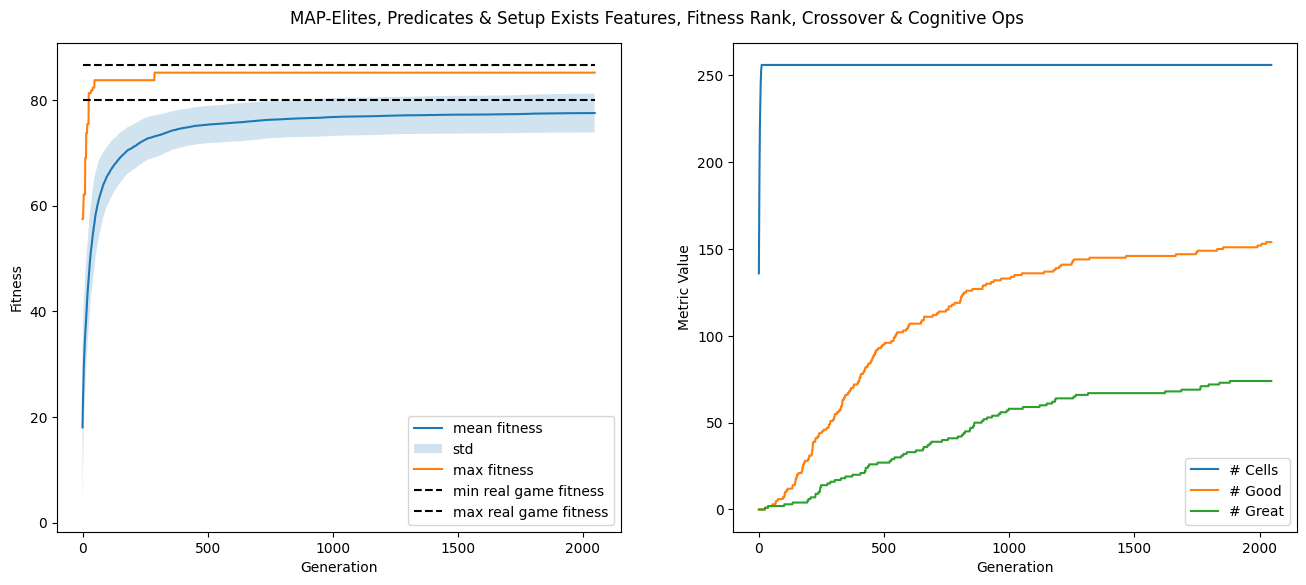

Saving representative games table to /Users/guydavidson/projects/game-generation-modeling/notebooks/output_htmls/representative_games_map_elites_specific_objects_ngram_specific_predicates_setup_2023_07_05.html


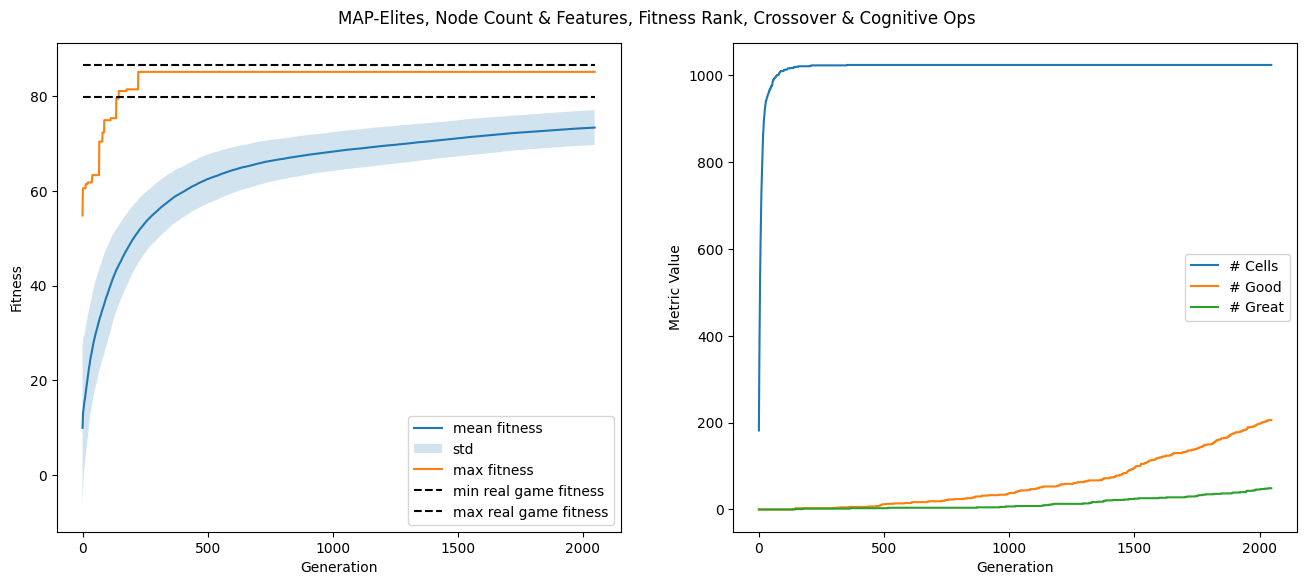

Saving representative games table to /Users/guydavidson/projects/game-generation-modeling/notebooks/output_htmls/representative_games_map_elites_specific_objects_ngram_node_count_specific_predicates_2023_07_05.html


In [36]:
# specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_30', 'samples', 'map_elites_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops',
#                                 min_real_game_fitness=61.4902, max_real_game_fitness=66.7565)

# node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_06_30', 'samples', 'map_elites_node_count_specific_predicates_final'))
# plot_sampler_fitness_trajectory(node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops',
#                                 min_real_game_fitness=61.4902, max_real_game_fitness=66.7565)

specific_objects_ngram_specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_07_04', 'samples', 'map_elites_specific_objects_ngram_specific_predicates_setup_final'))
plot_sampler_fitness_trajectory(specific_objects_ngram_specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops',
                                min_real_game_fitness=79.9283, max_real_game_fitness=86.6095)
make_and_save_representative_game_table(specific_objects_ngram_specific_predicates_setup, 'Specific objects ngram using predicates and setup bins', (79.9283, 86.6095))

specific_objects_ngram_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_07_04', 'samples', 'map_elites_specific_objects_ngram_node_count_specific_predicates_final'))  
plot_sampler_fitness_trajectory(specific_objects_ngram_node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops',
                                min_real_game_fitness=79.9283, max_real_game_fitness=86.6095)
make_and_save_representative_game_table(specific_objects_ngram_node_count_predicates, 'Specific objects ngram using predicates and node count bins', (79.9283, 86.6095))




In [ ]:
# model = specific_predicates_setup
# index = 1
# key = model.top_sample_key(index)
# sample = model.population[key]  # type: ignore


# # print(ast_str)
# # grammar_parser.parse(ast_str)

# game_fitness, game_features = model._score_proposal(sample, return_features=True)
# print(game_fitness)

# sample_copy = deepcopy_ast(sample)
# sample_copy = list(sample_copy)
# for i in range(len(sample_copy)):
#     if isinstance(sample_copy[i], tuple) and sample_copy[i][0] in (ast_parser.SETUP, ast_parser.TERMINAL) and len(sample_copy[i]) < 3:
#         sample_copy[i] = (*sample_copy[i], ')')
# sample_copy = tuple(sample_copy)

# copied_fitness, copied_features = model._score_proposal(sample_copy, return_features=True)
# print(copied_fitness)

# sample_copy_str = ast_printer.ast_to_string(sample_copy, '\n')
# reparsed_sample = grammar_parser.parse(sample_copy_str)
# reparsed_fitness, reparsed_features = model._score_proposal(reparsed_sample, return_features=True)
# print(reparsed_fitness)

# # {key: value for key, value in sample_features.items() if 'once' in key}
# for key in game_features:
#     if game_features[key] != reparsed_features[key]:
#         print(key, game_features[key], reparsed_features[key])

In [ ]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = specific_objects_ngram_node_count_predicates
index = 
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on, 
    postprocess_sample=True, features=key_features)
sample = model.population[key] 
# print_nearest_real_games(sample, n_similar_real_games_to_print)

In [ ]:



s = make_representative_game_table(specific_objects_ngram_node_count_predicates, REPRESENTATIVE_GAME_INDICES, increment='&nbsp;&nbsp;')

In [ ]:



make_representative_game_table_to_html(s)

In [ ]:
game = model.postprocessor(sample)
game_fitness, game_features = model._score_proposal(game, return_features=True)
{k: v for k, v in game_features.items() if 'setup_objects' in k}

In [ ]:
edited_game_str = """(define (game evo-2027-282-0) (:domain medium-objects-room-v1)
(:setup
  (and
    (exists (?v0 - hexagonal_bin)
      (game-conserved
        (and
          (adjacent bed ?v0)
          (equal_z_position bed ?v0)
        )
      )
    )
    (exists (?v1 - hexagonal_bin)
      (forall (?v2 - dodgeball)
        (game-optional
          (on bed ?v1)
        )
      )
    )
  )
)
(:constraints
  (and
    (preference preference0
      (exists (?v2 - dodgeball ?v3 - hexagonal_bin)
        (then
          (once (and (adjacent ?v3 agent) (agent_holds ?v2) ) )
          (hold (and (in_motion ?v2) (not (agent_holds ?v2) ) ) )
          (hold-while (in_motion ?v2) (not (agent_holds ?v2) ) )
          (once (and (not (in_motion ?v2) ) (in ?v3 ?v2) ) )
        )
      )
    )
  )
)
(:terminal
  (or
    (>= (count preference0) 3 )
    (>= (count preference0) 100 )
  )
)
(:scoring
  (* 300 (< (count preference0) (* 0.7 (count-once-per-objects preference0) )
    )
    (* 9 (= (count-once-per-objects preference0) (* 0.7 (count preference0) )
      )
    )
  )
)
)
"""
game = model.postprocessor(sample)
game_fitness, game_features = model._score_proposal(game, return_features=True)
game_features_tensor = model._features_to_tensor(game_features)

edited_game = grammar_parser.parse(edited_game_str)
edited_game_fitness, edited_game_features = model._score_proposal(edited_game, return_features=True)
edited_game_features_tensor = model._features_to_tensor(edited_game_features)
print(edited_game_fitness)

for key in game_features:
    if edited_game_features[key] != game_features[key]:
        print(key, game_features[key], edited_game_features[key])



utils.evaluate_comparison_energy_contributions(
    game_features_tensor, edited_game_features_tensor,
    ast_printer.ast_to_string(game, '\n'), edited_game_str,
    model._fitness_functions[0], model.feature_names,
)

In [ ]:
model = fitness_rank_predicates

def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(ast, map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(model, game_asts)
high_quality_sample_keys = set([k for k, v in model.fitness_values.items() if v > 70])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


high_quality_no_real_game_keys = [t[0] for t in sorted([(k, model.fitness_values[k]) for k in high_quality_sample_keys if k not in real_game_keys], key=lambda x: x[1], reverse=True)]

In [ ]:
index = 6
key = high_quality_no_real_game_keys[index]
n_features_on = None
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 
key_features = dict(section_doesnt_exist_setup=0)

key = model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

In [ ]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

In [ ]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [ ]:
fitness_df.groupby('real')[[c for c in fitness_df.columns if 'length_of_then' in c]].mean()